# PCA across compounds

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import xarray as xr

import shnitsel as sh
import shnitsel.xarray

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

## Load molecules

In [2]:
orig = {
    c: sh.open_frames(f'/tmp/{c}_filtered.nc')
    for c in ['I01', 'A01', 'A02', 'A03']
}

## Select homologous/isoelectronic moieties

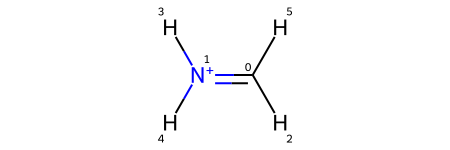

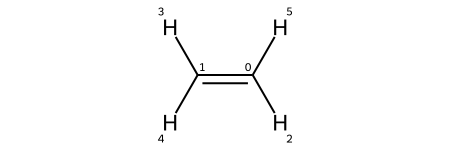

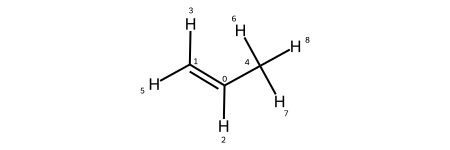

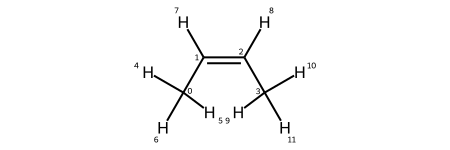

In [3]:
display(orig['I01'].atXYZ.isel(frame=0).sh.to_mol(+1))
display(orig['A01'].atXYZ.isel(frame=0).sh.to_mol())
display(orig['A02'].atXYZ.isel(frame=0).sh.to_mol())
display(orig['A03'].atXYZ.isel(frame=0).sh.to_mol())

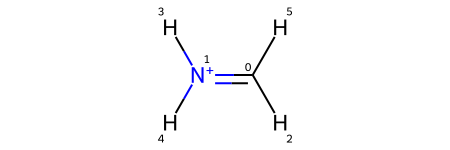

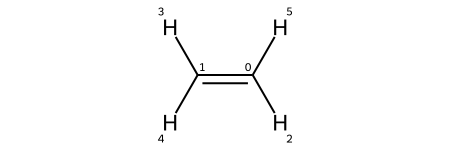

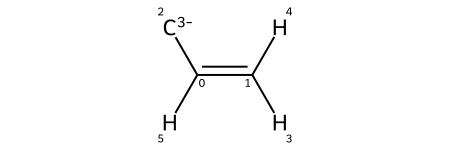

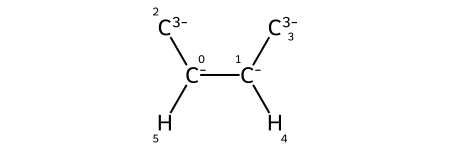

In [12]:
iso = {
    'I01': orig['I01'].drop_dims('state2'),
    'A01': orig['A01'].drop_dims('state2'),
    'A02': (
        orig['A02'].drop_dims('state2')
        .isel(atom=slice(0,6))
        # Put atom indices in order consistent with I01 & A01:
        .assign_coords(atom=[0, 1, 5, 3, 2, 4]).sortby('atom')),
    'A03': (
        orig['A03']
        .isel(atom=[0,1,2,3,7,8])
        # Put atom indices in order consistent with I01 & A01:
        .assign_coords(atom=[3, 1, 0, 2, 4, 5]).sortby('atom'))
}
display(iso['I01'].atXYZ.isel(frame=0).sh.to_mol(+1))
display(iso['A01'].atXYZ.isel(frame=0).sh.to_mol())
display(iso['A02'].atXYZ.isel(frame=0).sh.to_mol(-3))
display(iso['A03'].atXYZ.isel(frame=0).sh.to_mol(-8))

In [13]:
homologs = xr.concat(
    [iso[c].sh.expand_midx('frame', 'cmpnd', c) for c in iso],
    dim='frame'
)
homologs

<xarray.Dataset> Size: 340MB
Dimensions:    (state: 3, frame: 53332, direction: 3, statecomb: 3, atom: 6,
                trajid_: 255)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 1kB 2 3 6 13 17 19 20 ... 938 944 947 954 961 969
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 427kB MultiIndex
  * cmpnd      (frame) object 427kB 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid     (frame) int64 427kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    atNames    (frame, atom) <U1 1MB 'C' 'N' 'H' 'H' 'H' ... 'C' 'C' 'C' 'H' 'H'
Data variables: (12/13)
    energy     (state, frame) float64 1MB 0.3296 0.579 0.9188 ... 15.66 15.52
    dip_perm   (state, direction, frame) float64 4MB -0.001122 ... -0.01176
    dip_trans  (statecomb, direction, frame) float64 4MB 0.000616 ... 0.7723
    sdiag      (frame) int64 427kB 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 1 1 1
    astate     (frame) int64 427kB 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 1 1 1
    forces     (state, atom, direction, frame) float64 23MB 0.09112 0.0 ... 0.0
    ...         ...
    nacs       (statecomb, atom, direction, frame) float64 23MB 0.01589 ... -...
    atXYZ      (atom, direction, frame) float64 8MB 0.01587 0.01682 ... -1.382
    max_ts     (trajid_, frame) float64 109MB 200.0 200.0 200.0 ... nan nan nan
    completed  (trajid_, frame) float32 54MB 1.0 1.0 1.0 1.0 ... nan nan nan nan
    nsteps     (trajid_, frame) float64 109MB 201.0 201.0 201.0 ... nan nan nan
    e_kin      (frame) float64 427kB nan nan nan nan ... 6.424 6.936 7.527 8.137
Attributes:
    delta_t:  0.5

In [14]:
pca = homologs.atXYZ.sh.pairwise_dists_pca()
pca

<xarray.DataArray (frame: 53332, PC: 2)> Size: 853kB
array([[-0.49254555, -0.18807667],
       [-0.4943486 , -0.16643753],
       [-0.48172495, -0.14110762],
       ...,
       [ 0.53443245, -0.07225063],
       [ 0.53119398, -0.08579228],
       [ 0.52652913, -0.0981503 ]], shape=(53332, 2))
Coordinates:
  * frame    (frame) object 427kB MultiIndex
  * cmpnd    (frame) object 427kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid   (frame) int64 427kB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time     (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Dimensions without coordinates: PC

Text(0.02, 0.5, 'PC2')

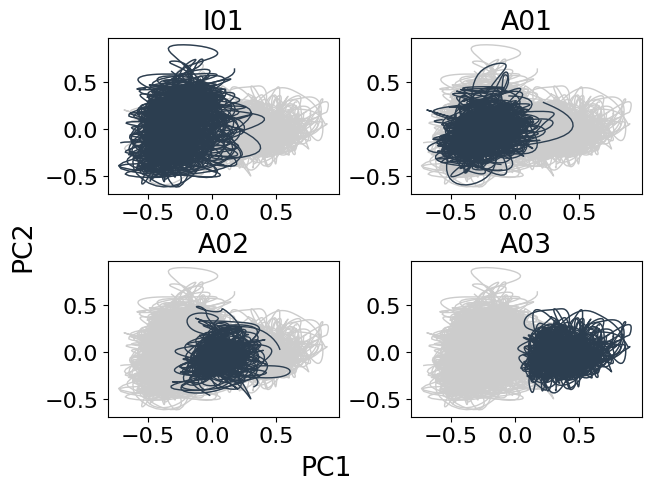

In [15]:
fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

for name, ax in axs.items():
    ax.set_title(name)
    for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        axs[cmpnd].plot(traj[:,0], traj[:,1], c='#2c3e50')

fig.supxlabel('PC1')
fig.supylabel('PC2')

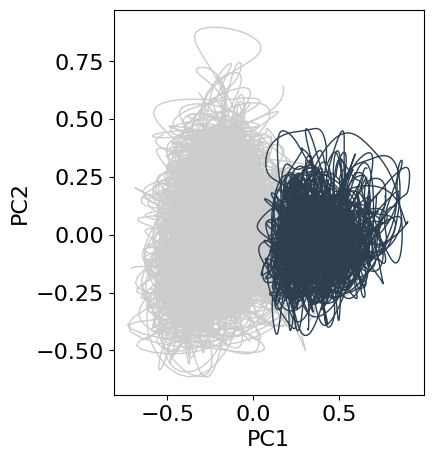

In [16]:
plt.rc('font', size=16)
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 5)
for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd == 'A03':
        ax.plot(traj[:,0], traj[:,1], c='#2c3e50', zorder=10)
    else:
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
fig.savefig('/nc/reports/2025-06-30_4-step_figure/2.pdf')

# TODO: Alter to use butene-fitted PCA

In [22]:
homologs.sh.save_frames('/tmp/homologs.nc', complevel=5)

## Extension: Plot with loadings

sweeping clock from -25°
swept to -65°
sweeping anti from 25°
swept to 55°


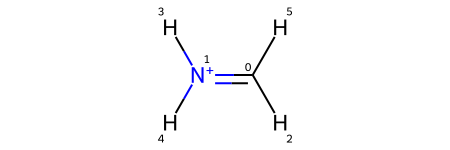

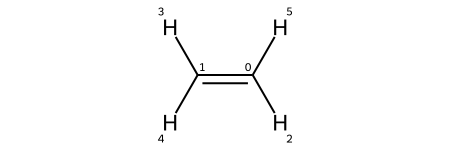

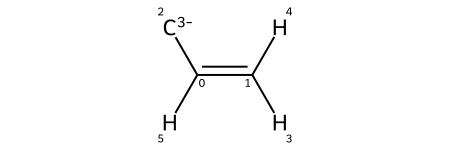

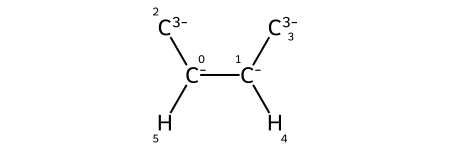

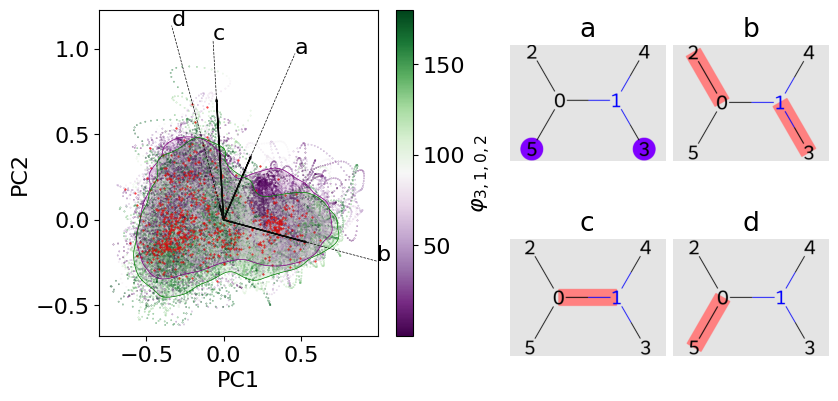

In [23]:
sh.plot.biplot_kde(homologs, 3, 1, 0, 2, scatter_color='geo')
display(iso['I01'].atXYZ.isel(frame=0).sh.to_mol(+1,to2D=True))
display(iso['A01'].atXYZ.isel(frame=0).sh.to_mol(to2D=True))
display(iso['A02'].atXYZ.isel(frame=0).sh.to_mol(-3,to2D=True))
display(iso['A03'].atXYZ.isel(frame=0).sh.to_mol(-8,to2D=True))

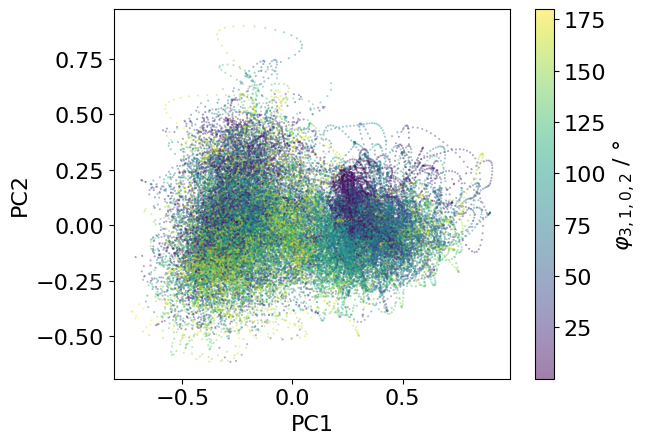

In [20]:
pca = homologs.atXYZ.sh.pairwise_dists_pca()
dih = homologs.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
pca['dih'] = dih
plt.scatter(pca[:, 0], pca[:, 1], c=pca['dih'], s=0.2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label=dih.attrs['long_name'] + ' / °')

In [58]:
pca, pca_obj = iso['A03'].atXYZ.sh.subtract_combinations('atom').sh.norm().sh.pca('atomcomb', return_pca_object=True)
pca = pca_obj.transform(homologs.atXYZ.sh.subtract_combinations('atom').sh.norm().T)
pca = homologs.atXYZ.sh.pairwise_dists_pca().copy(data=pca)
pca['dih'] = homologs.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
pca['is_hop'] = homologs.astate.sh.sudi() != 0
pca['astate'] = homologs.astate
pca

<xarray.DataArray (frame: 53332, PC: 2)> Size: 853kB
array([[3.10573209, 3.07713602],
       [3.09138364, 3.08544055],
       [3.10009847, 3.10754998],
       ...,
       [5.40543614, 2.79761418],
       [5.40205766, 2.81539413],
       [5.39699692, 2.8379851 ]], shape=(53332, 2))
Coordinates:
  * frame    (frame) object 427kB MultiIndex
  * cmpnd    (frame) object 427kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid   (frame) int64 427kB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time     (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    dih      (frame) float64 427kB 2.197 2.186 2.344 2.744 ... 157.8 160.7 163.7
    is_hop   (frame) bool 53kB False False False False ... False False False
    astate   (frame) int64 427kB 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: PC

Text(0.02, 0.5, 'PC2')

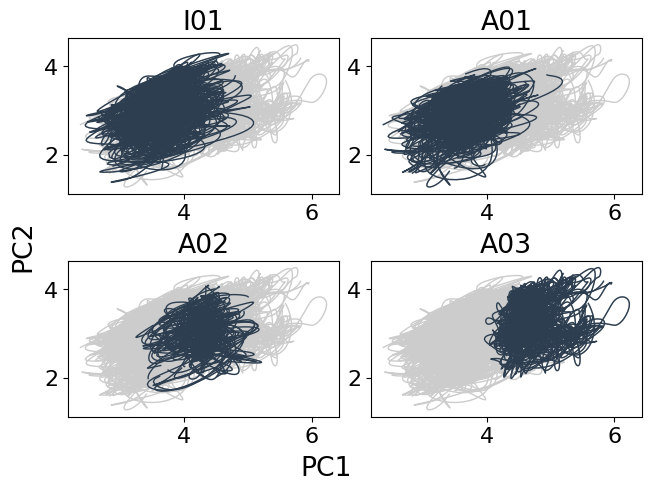

In [41]:
fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

for name, ax in axs.items():
    ax.set_title(name)
    for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        axs[cmpnd].plot(traj[:,0], traj[:,1], c='#2c3e50')

fig.supxlabel('PC1')
fig.supylabel('PC2')

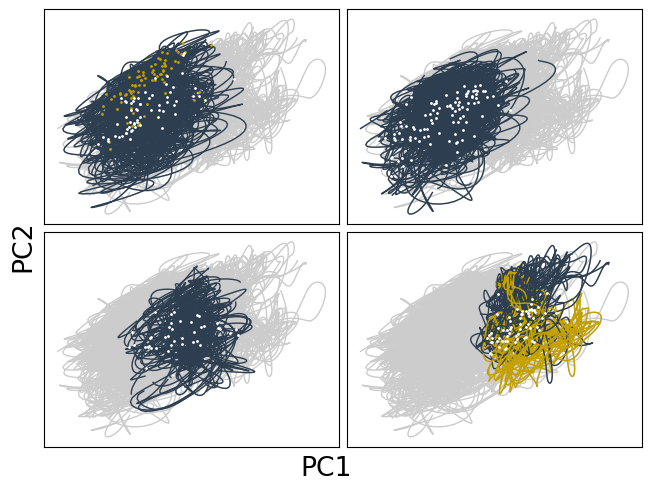

In [99]:
fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

for name, ax in axs.items():
    # ax.set_title(name)

    # ax.axis('on')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.tick_params(axis="x", bottom=False, labelbottom=False)

    for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='#ccc')# , alpha=0.5)

for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd != 'A03':
        c = '#2c3e50' #'#7E5273'
    elif traj['dih'].isel(frame=-1) < 80:
        c = '#2c3e50'
    elif traj['dih'].isel(frame=-1) >= 100:
        c = '#C4A000'
    else:
        continue
        
    axs[cmpnd].plot(traj[:,0], traj[:,1], c=c, zorder=9)#, alpha=0.5)
    hops = traj[traj['is_hop']]
    if hops.sizes['frame'] == 0:
        continue
    for astate, hop_group in hops.groupby('astate'):
        if cmpnd == 'I01':
            match astate:
                case 2: c = '#C4A000'
                case 1: c = 'white'
        else:
            c = 'white'
        if cmpnd == 'A01' and astate == 2:
            continue
        axs[cmpnd].scatter(hop_group[:, 0], hop_group[:, 1], zorder=10, c=c, s=1)
    
fig.supxlabel('PC1')
fig.supylabel('PC2')

fig.savefig('/nc/reports/2025-06-30_4-step_figure/pca_homologs.pdf')
fig.savefig('/nc/reports/2025-06-30_4-step_figure/pca_homologs.png')

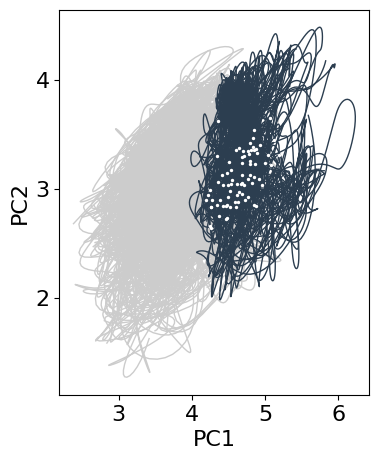

In [80]:
plt.rc('font', size=16)
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 5)
for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd == 'A03':
        ax.plot(traj[:,0], traj[:,1], c='#2c3e50', zorder=10)
        hops = traj[traj['is_hop']]
        ax.scatter(hops[:, 0], hops[:, 1], zorder=11, c='white', s=2)
    else:
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xticks([3, 4, 5, 6])
ax.set_yticks([2, 3, 4])
fig.savefig('/nc/reports/2025-06-30_4-step_figure/2.pdf')
fig.savefig('/nc/reports/2025-06-30_4-step_figure/2.png')

# TODO: Alter to use butene-fitted PCA

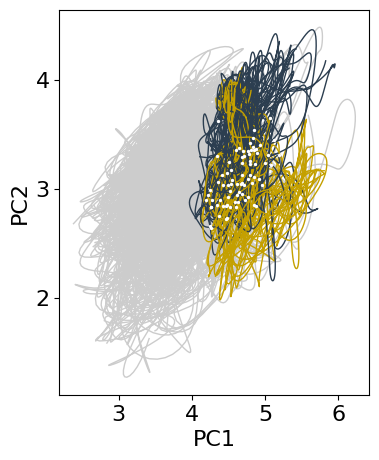

In [102]:
plt.rc('font', size=16)
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 5)
for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd == 'A03':
        if traj['dih'].isel(frame=-1) < 80:
            c = '#2c3e50'
            zorder = 10
        elif traj['dih'].isel(frame=-1) > 100:
            c = '#C4A000'
            zorder = 10
        else:
            c = '#ccc'
            zorder = 9
        ax.plot(traj[:,0], traj[:,1], c=c, zorder=zorder)
        hops = traj[traj['is_hop']]
        ax.scatter(hops[:, 0], hops[:, 1], zorder=11, c='white', s=2)

    else:
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xticks([3, 4, 5, 6])
ax.set_yticks([2, 3, 4])
fig.savefig('/nc/reports/2025-06-30_4-step_figure/3.pdf')
fig.savefig('/nc/reports/2025-06-30_4-step_figure/3.png')